In [29]:
import os
import numpy as np
import pandas as pd

os.chdir('../core')

: 

In [23]:
DATA_DIR = "../data"
FILE_NAME = "data.csv"

df = pd.read_csv(os.path.join(DATA_DIR, FILE_NAME))
df = df.drop(columns=["Cus.ID"])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
#df["Attrition"] = df["Attrition"].map({"Stayed": 1, "Left": 0})
df["Does he/she Come from Facebook Page?"] = df["Does he/she Come from Facebook Page?"].map({"Yes": 1, "No": 0})
print(df.shape)

df.head(5)

(8871, 10)


,Date,Cus. Location,Age,Gender,Mobile Name,Sell Price,Does he/she Come from Facebook Page?,Does he/she Followed Our Page?,Did he/she buy any mobile before?,Did he/she hear of our shop before?
0,14-08-2024,Rangamati Sadar,49,M,iQOO Neo 9 Pro 5G 12/256,23271.0,0,Yes,No,Yes
1,24-12-2024,Inside Rangamati,22,F,Redmi Note 12 Pro 8/128,21682.0,1,Yes,Yes,No
2,23-10-2024,Outside Rangamati,48,M,Narzo N53 4/64,13161.0,0,No,No,Yes
3,08-11-2024,Outside Rangamati,38,M,Redmi Note 12 Pro 8/128,26133.0,0,No,No,Yes
4,03-06-2024,Rangamati Sadar,34,F,iPhone 16 Pro 256GB,26221.0,0,No,No,Yes


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from processor import LabelEncoderTransformer


target_column = "Does he/she Come from Facebook Page?"

# Choose numeric columns except the target column
numeric_columns = df.drop(columns=[target_column]).select_dtypes(include=['int64', 'float64']).columns.tolist()
category_columns = df.select_dtypes(include=['object']).columns.tolist()

processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', LabelEncoderTransformer(), category_columns)
    ]
)

X = processor.fit_transform(df.drop(columns=[target_column]), df[target_column])
y = df[target_column].values.reshape(-1, 1)

X

array([[ 1.55889100e+00, -9.96787845e-02,  1.35000000e+02, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-1.25593392e+00, -1.87800947e-01,  2.37000000e+02, ...,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.45463822e+00, -6.60355350e-01,  2.26000000e+02, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.55889100e+00, -6.04620439e-01,  2.54000000e+02, ...,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [-1.36018669e+00, -2.14808809e-01,  2.40000000e+02, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-7.34670043e-01,  7.72336874e-01,  2.76000000e+02, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00]],
      shape=(8871, 9))

# Ours

In [25]:
folder = "compare"
folder_path = f"../images/{folder}"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Parameters for plot
fontsize = 17
offset = 4

In [34]:
from base import (
    LogisticRegressionGD,
    LogisticRegressionBatchGD,
    LogisticRegressionAcceleration,
    LogisticRegressionNewton,
    LogisticRegressionBFGS,
    LogisticRegressionAdam
)

num_interations = 200
regularization = "None"
lambda_ = 0.5

# Tinh chỉnh learning rate để các thuật toán hội tụ tương đương
base_gd = LogisticRegressionGD(
    learning_rate=0.1,  # Giảm từ 0.4 để ổn định hơn
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

sgd = LogisticRegressionBatchGD(
    learning_rate=0.001,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
    batch_size=1,
)

minibatch_gd = LogisticRegressionBatchGD(
    learning_rate=0.05,  # Tăng từ 0.01 để rõ ràng hơn
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
    batch_size=256,
)

pa = LogisticRegressionAcceleration(
    learning_rate=0.1,  # Giảm từ 0.4 để ổn định
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

newton = LogisticRegressionNewton(
    learning_rate=0.5,  # Giảm từ 1.5 để tránh overshooting
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

bfgs = LogisticRegressionBFGS(
    learning_rate=0.3,  # Giảm từ 0.8 để ổn định
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

adam = LogisticRegressionAdam(
    learning_rate=0.05,  # Giảm từ 0.1 để so sánh fair hơn
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

models = [
    base_gd, 
    sgd, 
    minibatch_gd, 
    pa, 
    newton, 
    bfgs, 
    adam
]

names = [
    "GD", 
    "SGD", 
    "Mini-batch GD (256)", 
    "Accelerated GD", 
    "Newton", 
    "BFGS", 
    "Adam"
]

loggers = []
for model, name in zip(models, names):
    logger = {}
    model.fit(X, y)

    logger["name"] = name
    logger["loss"] = model.history
    logger["time"] = model.times
    
    loggers.append(logger)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9088\181190787.py:24: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(np.log(logger["time"]), logger["loss"], label=logger["name"])


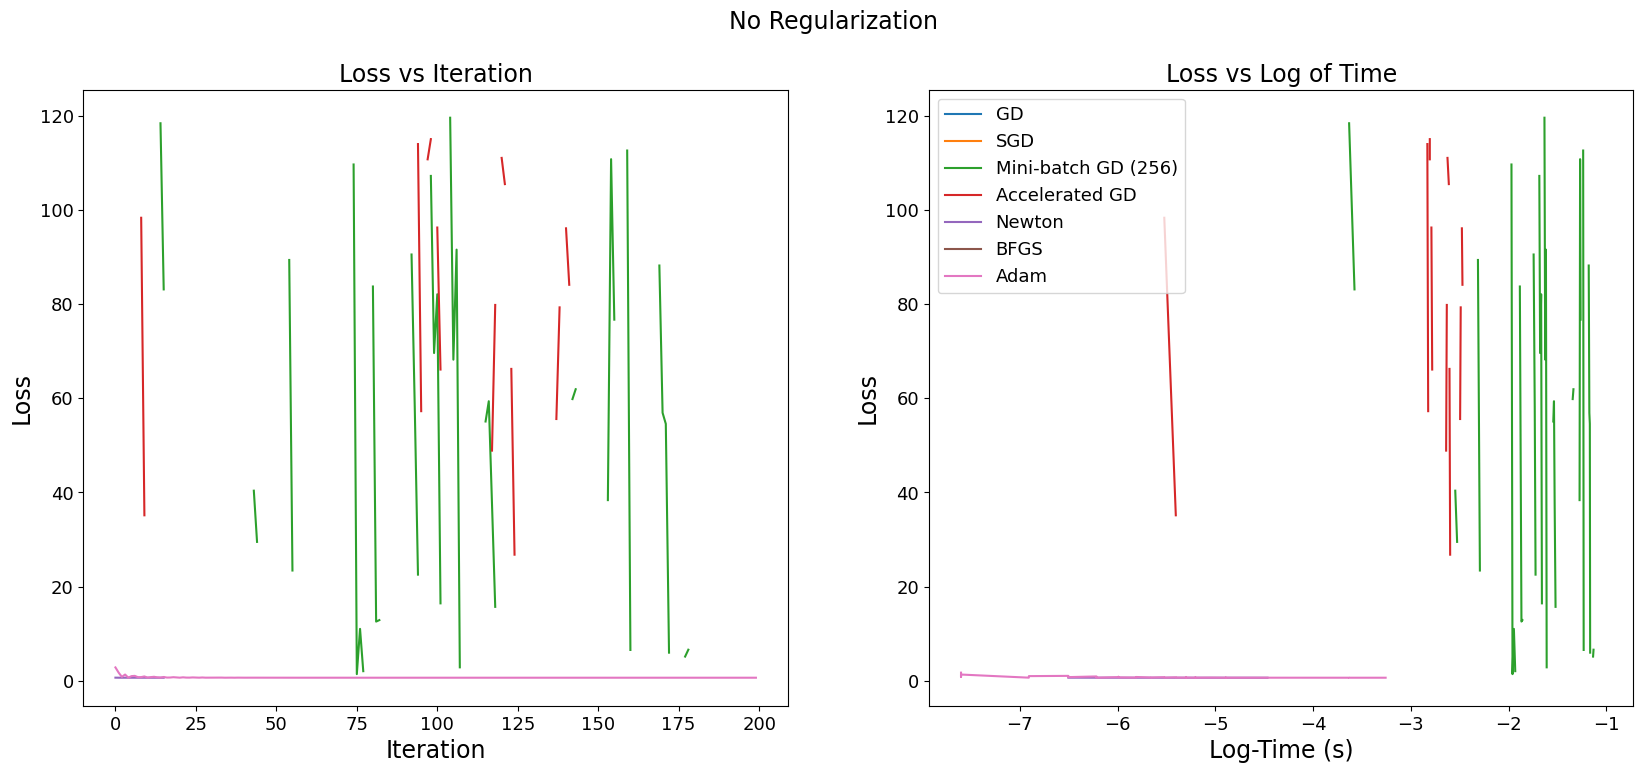

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Plot loss for each learning rate with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Title for the subplots
fig.suptitle("No Regularization", fontsize=fontsize)

# Plot loss vs iteration
axs[0].set_title("Loss vs Iteration", fontsize=fontsize)
for logger in loggers:
    axs[0].plot(logger["loss"], label=logger["name"])

axs[0].set_xlabel("Iteration", fontsize=fontsize)
axs[0].set_ylabel("Loss", fontsize=fontsize)
axs[0].tick_params(axis='x', labelsize=fontsize - offset)
axs[0].tick_params(axis='y', labelsize=fontsize - offset)
# axs[0].legend()

# Plot loss vs time
axs[1].set_title("Loss vs Log of Time", fontsize=fontsize)
for logger in loggers:
    axs[1].plot(np.log(logger["time"]), logger["loss"], label=logger["name"])

axs[1].set_xlabel("Log-Time (s)", fontsize=fontsize)
axs[1].set_ylabel("Loss", fontsize=fontsize)
axs[1].tick_params(axis='x', labelsize=fontsize - offset)
axs[1].tick_params(axis='y', labelsize=fontsize - offset)
axs[1].legend(fontsize=fontsize - offset)

# Save image
file_path = f"{folder_path}/ours_loss_no_regularization.png"
plt.savefig(file_path, format='png')
plt.show()

# Vs Scikit-learn

# Compare loss

In [33]:
# Sklearn Model
from sklearn.linear_model import LogisticRegression
from base import LogisticRegressionBFGS

# Our Model
bfgs = LogisticRegressionBFGS(
    learning_rate=0.8,
    num_iterations=200,
    regularization="None",
    fit_intercept=True, 
    log=True,
)


max_iters = 200
loss_loggers = {}

# Fit our model
bfgs.fit(X, y)
loss_loggers["BFGS (Ours)"] = bfgs.history

# Fit Sklearn model
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss_function(theta, X, y):
    z = np.dot(X, theta)
    h = sigmoid(z)
    return -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))

scikit_loss = []
X_ = np.hstack((np.ones((X.shape[0], 1)), X))
for i in range(1, max_iters+1):
    model = LogisticRegression(
        max_iter=i,
        fit_intercept=True,
        penalty="none",
        tol=1e-3
    )
    model.fit(X, y.ravel())

    coef = model.coef_.reshape(-1, 1)
    intercept = model.intercept_

    theta = np.vstack((intercept, coef))
    loss = loss_function(theta, X_, y)
    scikit_loss.append(loss)

loss_loggers["Scikit-learn"] = scikit_loss

d:\DungVTT\Master-DataScience\Tối ưu hóa lâng cao\optimization-algorithms-analysis\core\base.py:48: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
d:\DungVTT\Master-DataScience\Tối ưu hóa lâng cao\optimization-algorithms-analysis\core\base.py:398: RuntimeWarning: divide by zero encountered in log
  (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
d:\DungVTT\Master-DataScience\Tối ưu hóa lâng cao\optimization-algorithms-analysis\core\base.py:398: RuntimeWarning: invalid value encountered in multiply
  (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
d:\DungVTT\Master-DataScience\Tối ưu hóa lâng cao\optimization-algorithms-analysis\core\base.py:51: RuntimeWarning: divide by zero encountered in log
  return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
d:\DungVTT\Master-DataScience\Tối ưu hóa lâng cao\optimization-algorithms-analysis\core\base.py:51: RuntimeWarning: invalid value encountered in multiply
  return (-y * np.log(h) - (1 - y) * np.log(1 - h)).m

InvalidParameterError: The 'penalty' parameter of LogisticRegression must be a str among {'elasticnet', 'l2', 'l1'} or None. Got 'none' instead.

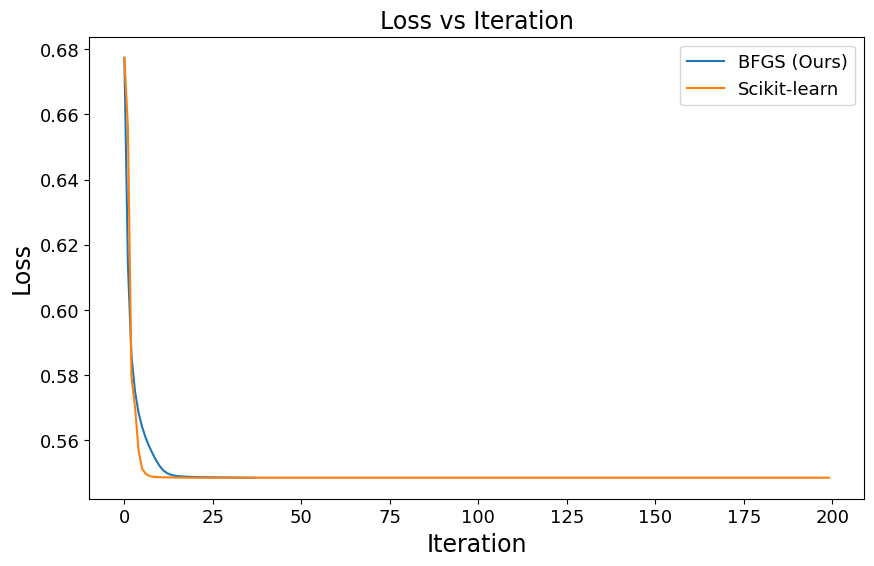

In [17]:
from matplotlib import pyplot as plt

# Plot loss 
plt.figure(figsize=(10, 6))
plt.title("Loss vs Iteration", fontsize=fontsize)
for name, loss in loss_loggers.items():
    plt.plot(loss, label=name)

plt.xlabel("Iteration", fontsize=fontsize)
plt.ylabel("Loss", fontsize=fontsize)
plt.tick_params(axis='x', labelsize=fontsize - offset)
plt.tick_params(axis='y', labelsize=fontsize - offset)
plt.legend(fontsize=fontsize - offset)

# Save image
file_path = f"{folder_path}/compare_loss_no_regularization.png"
plt.savefig(file_path, format='png')

plt.show()

# Compare Time and Acc

In [22]:
from base import BaseLR
from time import time

# Romove log in class
class LogisticRegressionBFGS(BaseLR):
    def __init__(
        self,
        learning_rate=0.01,
        num_iterations=100,
        regularization="None",
        lambda_=1.0,
        fit_intercept=True,
        log=True,
        tol=1e-3
    ):
        super().__init__(learning_rate, num_iterations, regularization, lambda_, fit_intercept, log, tol)
        
    def fit(self, X, y):
        if self.fit_intercept:
            X = super()._BaseLR__add_intercept(X)
        
        self.theta = np.zeros((X.shape[1], 1))
        z = np.dot(X, self.theta)
        h = super()._BaseLR__sigmoid(z)
        gradient = self.gradient(h, y, X, self.theta)

        H = np.eye(X.shape[1])
        
        for _ in range(self.num_iterations):
            p = -H @ gradient
            s = self.learning_rate * p
            theta_new = self.theta + s
            
            z_new = np.dot(X, theta_new)
            h_new = super()._BaseLR__sigmoid(z_new)
            gradient_new = self.gradient(h_new, y, X, theta_new)
            
            delta_gradient = gradient_new - gradient
            
            r = 1/(delta_gradient.T@s)
            
            li = (np.eye(X.shape[1])-(r*((s@(delta_gradient.T)))))
            ri = (np.eye(X.shape[1])-(r*((delta_gradient@(s.T)))))
            
            H = li @ H @ ri + (r*((s@(s.T))))
            
            gradient = gradient_new
            self.theta = theta_new

            # Check to stop early
            if np.linalg.norm(gradient) < self.tol:
                break

In [25]:
# Our Model
bfgs = LogisticRegressionBFGS(
    learning_rate=0.8,
    num_iterations=200,
    regularization="None",
    fit_intercept=True, 
    log=True,
)

# Sklearn Model
from sklearn.linear_model import LogisticRegression

sklearn_lr = LogisticRegression(
    penalty=None,
    fit_intercept=True,
    max_iter=200,
    random_state=42,
    tol=1e-3
)

# Run 10 times to get a list of time
# After that plot boxplot
num_turns = 50

times = {
    "Ours": [],
    "Scikit-learn": []
}

for _ in range(num_turns):
    start = time()
    bfgs.fit(X, y)
    times["Ours"].append(time() - start)

    start = time()
    sklearn_lr.fit(X, y.ravel())
    times["Scikit-learn"].append(time() - start)


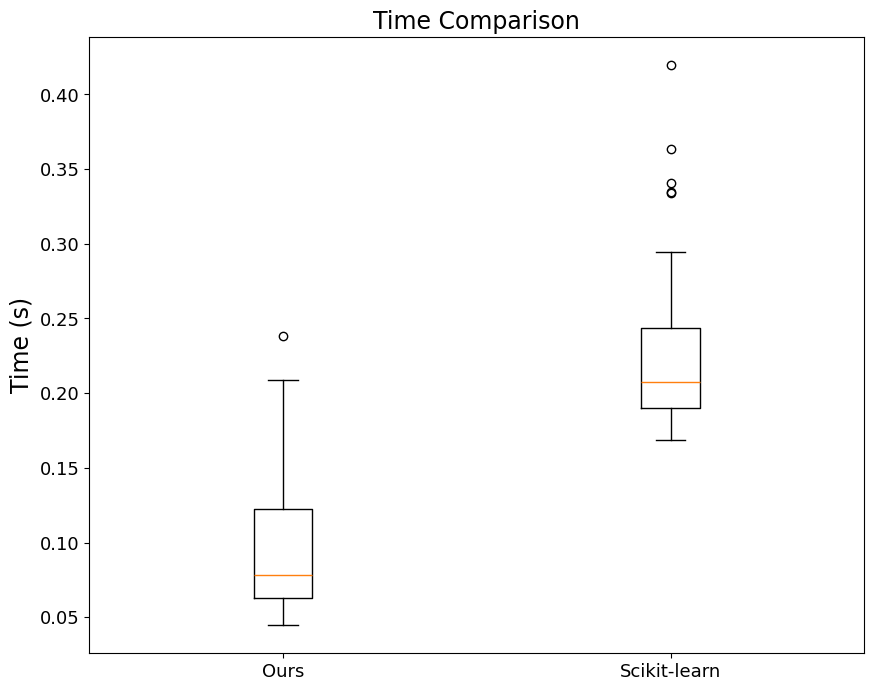

In [26]:
from matplotlib import pyplot as plt

# Plot boxplot
fig, ax = plt.subplots(figsize=(10, 8))

ax.boxplot(times.values())
ax.set_xticklabels(times.keys())
ax.set_title("Time Comparison", fontsize=fontsize)
ax.set_ylabel("Time (s)", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize - offset)
ax.tick_params(axis='y', labelsize=fontsize - offset)

# Save image
file_path = f"{folder_path}/time_comparison.png"

plt.savefig(file_path, format='png')
plt.show()

In [11]:
# Run cross validation
from sklearn.model_selection import cross_val_score

# Our Model
bfgs = LogisticRegressionBFGS(
    learning_rate=0.4,
    num_iterations=200,
    regularization="None",
    fit_intercept=True, 
    log=True,
)

# Sklearn Model
from sklearn.linear_model import LogisticRegression

sklearn_lr = LogisticRegression(
    penalty='none',
    fit_intercept=True,
    max_iter=200,
    random_state=42,
    tol=1e-3
)

# Split data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

num_turns = 50

scores = {
    "Ours": [],
    "Scikit-learn": []
}

for _ in range(num_turns):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    bfgs.fit(X_train, y_train)
    y_predict = bfgs.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    scores["Ours"].append(accuracy)

    sklearn_lr.fit(X_train, y_train)
    y_predict = sklearn_lr.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    scores["Scikit-learn"].append(accuracy)



/home/quyanh/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/quyanh/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/quyanh/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/quyanh/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

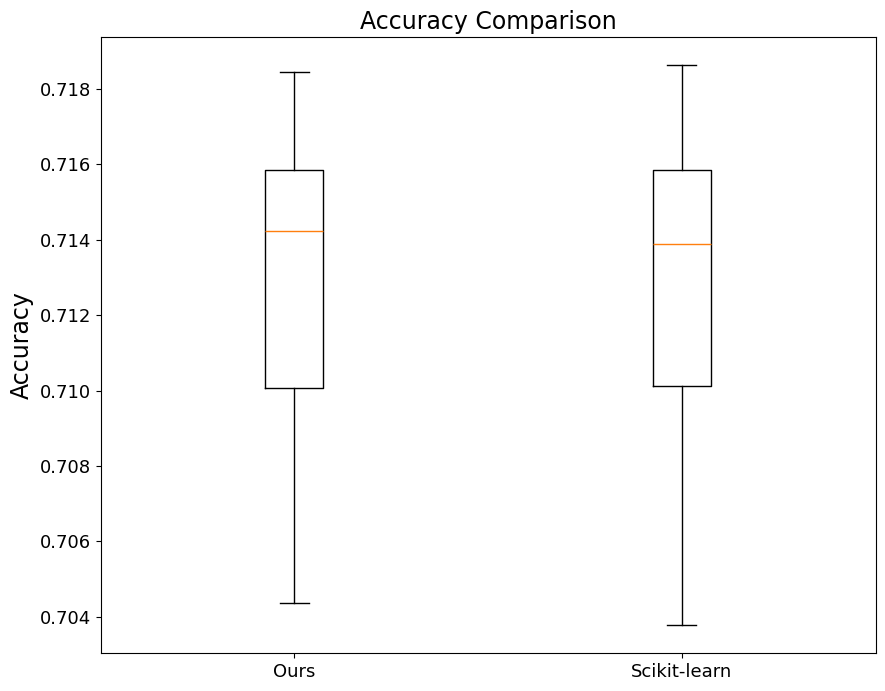

In [12]:
from matplotlib import pyplot as plt

# Plot boxplot
fig, ax = plt.subplots(figsize=(10, 8))

ax.boxplot(scores.values())
ax.set_xticklabels(scores.keys())
ax.set_title("Accuracy Comparison", fontsize=fontsize)
ax.set_ylabel("Accuracy", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize - offset)
ax.tick_params(axis='y', labelsize=fontsize - offset)

# Save image
file_path = f"{folder_path}/accuracy_comparison.png"

plt.savefig(file_path, format='png')

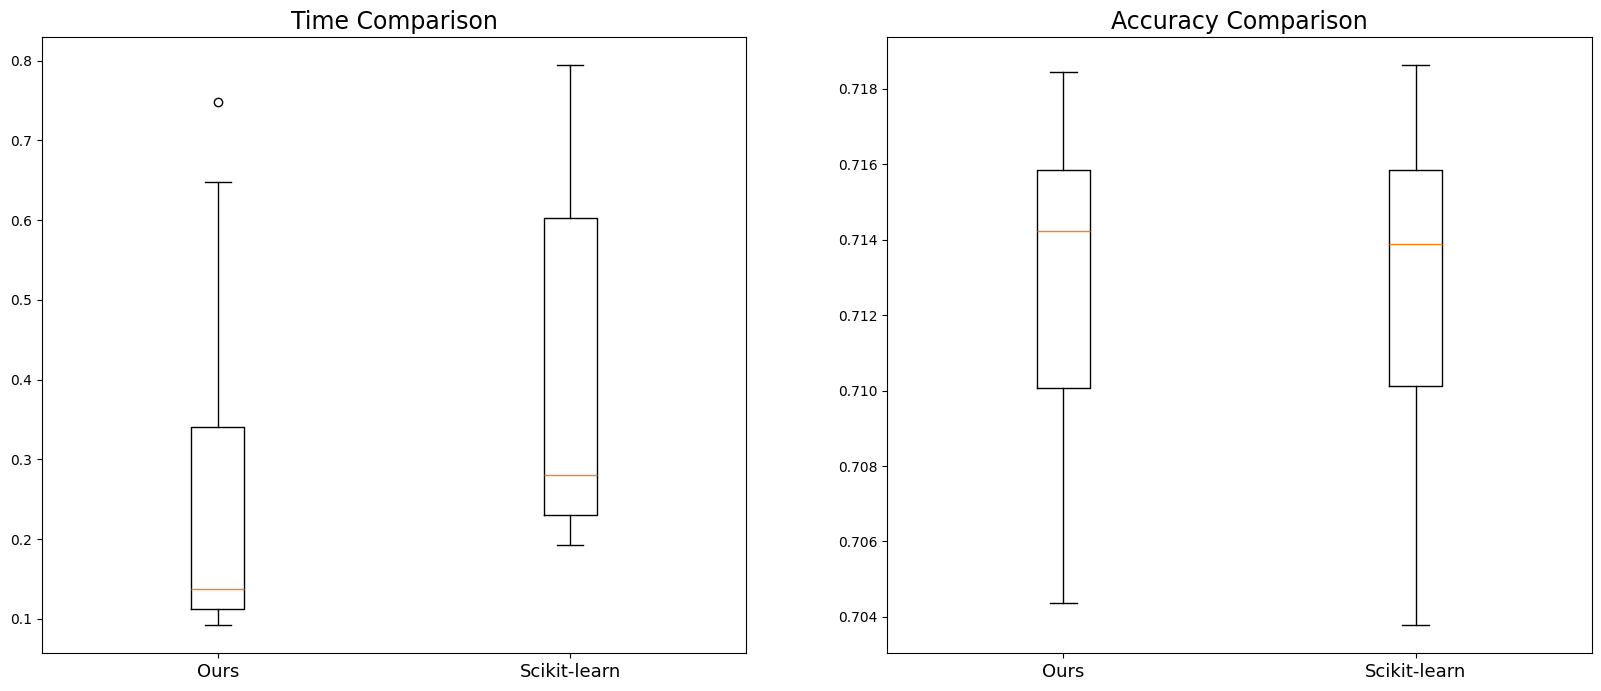

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Title for the subplots
# fig.suptitle("Comparision between Our Algorithm and Scikit-learn's Algorithm", fontsize=fontsize)

# Plot time
axs[0].boxplot(times.values())
axs[0].set_xticklabels(times.keys(), fontsize=fontsize - offset)
axs[0].set_title("Time Comparison", fontsize=fontsize)

# Plot accuracy
axs[1].boxplot(scores.values())
axs[1].set_xticklabels(scores.keys(), fontsize=fontsize - offset)
axs[1].set_title("Accuracy Comparison", fontsize=fontsize)

# Save image
file_path = f"{folder_path}/comparison.png"
plt.savefig(file_path, format='png')

plt.show()